The question addressed here is, if we are using ReadUntil and human genomic DNA with no amplification, can we achieve reasonable coverage of the HLA region.

In [1]:
human_genome_size = 3e9
hla_size = 3.6e6                   # classical MHC is 3.6Mb
readuntil_thresh = 250             # events until readuntil kicks in, which is ~= bases
max_num_pores = 512                # only pores, i am not modeling channels since remuxing happens after 24hr
read_bases_per_second = 250        # R9
num_active_pores = 350             # empirical, out of 512
p_dna_in_pore = 0.01               # empirical, no idea what this should be
p_pore_blocked = 0.001             # empirical, after a read goes through, it might get blocked

In [3]:
p_hla = hla_size / human_genome_size
def is_hla():
    return np.random.random() < p_hla
print("Fraction of reads that will overlap HLA: {:.3g}".format(p_hla))

Fraction of reads that will overlap HLA: 0.0012


In [2]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from heapq import heappop, heappush

%matplotlib inline
%load_ext line_profiler
%config InlineBackend.figure_format = 'retina'

/Users/briann/anaconda/envs/py3k/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


DNA fragment lengths
--------------------
In this simulation, readlength is identical to the lengths of DNA in solution (i.e., each DNA fragment is read in its entirety)

mean readlength: 13506, std: 16747


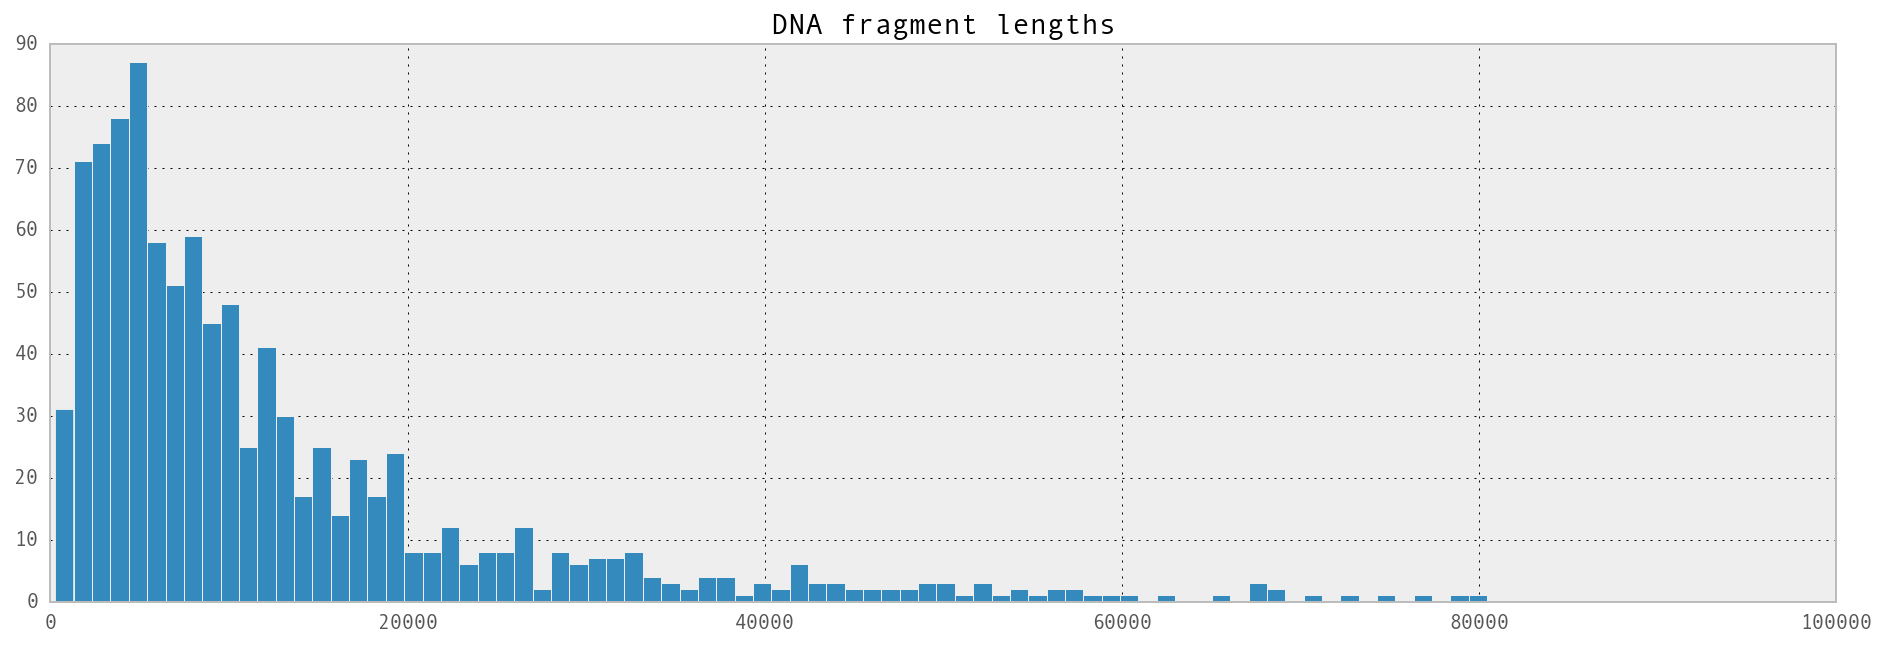

In [6]:
dna_lens = np.random.lognormal(9,1,1000).astype(np.int)
print("mean readlength: {:d}, std: {:d}".format(int(dna_lens.mean()), int(dna_lens.std())))

fig, ax = plt.subplots(1, 1, figsize=(16,5))
ax.set_xlim(0,100000)
ax.set_title("DNA fragment lengths")
_ = ax.hist(dna_lens, bins=200)

In [29]:
import random
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

Simulation
--------------
Simulate events using a priority queue.

In [ ]:
def time_to_load_dna_gen():
    N = 10000
    times = np.random.lognormal(3,1,size=N)
    print("Avg time to load DNA:\t{:.1f}s".format( np.mean(times) ))
    assert np.all(times>0), "lognormal should not return values <=0"
    yield from (times[i%N] for i in count())   
time_to_load_dna = time_to_load_dna_gen()

def new_dna_len_gen():
    N = 10000
    dna_lens = np.random.lognormal(9,1,size=N).astype(np.int)
    print("Avg DNA fragment length:\t{:.0f}".format( np.mean(dna_lens) ))
    assert np.all(dna_lens>0), "lognormal should not return values <=0"
    yield from (dna_lens[i%N] for i in count())
new_dna_len = new_dna_len_gen()

def time_to_read_dna(dna_len):
    return dna_len / read_bases_per_second

def is_blocked():
    return np.random.random() < p_pore_blocked

Event = namedtuple("event", ['time', 'pore', 'type', 'dna_len'])
class Task(object): # do not use Enum since it is unordered so breaks heap
    NOTHING, FOUND_DNA, DO_READUNTIL, END_READ = range(4)

def run_sim(run_hours, READUNTIL_HLA=True):
    queue = []
    def enqueue(this_time, prev_time, pore, etype, dna_len):
        heappush(queue, Event(this_time + prev_time, pore, etype, dna_len))
    
    run_time_sec = run_hours * 60 * 60    
    total_reads = []
    total_hla_reads = []
    total_pores_blocked = 0
    
    for i in range(num_active_pores):
        enqueue(next(time_to_load_dna), 0, i, Task.FOUND_DNA, None)
    
    while True:
        if len(queue) == 0:
            logging.warning("Empty queue (no active pores remain!)")
            break
        
        is_end_of_read = False
        event = heappop(queue)

        if event.time > run_time_sec:
            # cleanup()?
            break
        
        if event.type == Task.FOUND_DNA:
            dna_len = next(new_dna_len)
            if READUNTIL_HLA:
                enqueue(time_to_read_dna(readuntil_thresh), event.time, event.pore, Task.DO_READUNTIL, dna_len)
            else:
                enqueue(time_to_read_dna(dna_len), event.time, event.pore, Task.END_READ, dna_len)
        elif event.type == Task.DO_READUNTIL:
            if is_hla():
                enqueue(time_to_read_dna(max(0,event.dna_len-readuntil_thresh)), event.time, event.pore, Task.END_READ, event.dna_len)
            else:
                total_reads.append(readuntil_thresh)
                is_end_of_read = True
        elif event.type == Task.END_READ:
            total_reads.append(event.dna_len)
            total_hla_reads.append(event.dna_len)
            is_end_of_read = True
        else:
            raise ValueError("unknown Task")
    
        if is_end_of_read:
            #import random
            #gpore = p.select(dict(name="pore_0"))
            #gpore[0].glyph.fill_color=random.choice(["#ff0000", "#00ff00"])

            if not is_blocked():
                enqueue(next(time_to_load_dna), event.time, event.pore, Task.FOUND_DNA, None)
            else:
                total_pores_blocked += 1
    
    print("\n[{:.1f} hour expt{}]".format(run_hours, " (HLA)" if READUNTIL_HLA else ""))
    print("Total DNA read:\t\t{:d} bases ({:.1f} Mb) in {:d} reads".format(sum(total_reads), sum(total_reads)/1e6, len(total_reads)))
    print("Total pores blocked:\t{:d} / {:d}".format(total_pores_blocked, num_active_pores))
    if READUNTIL_HLA:
        tot_hla = int(sum(total_hla_reads))
        print("HLA: total DNA read:\t{:d} bases ({:.1f} Mb) in {:d} reads ({:.1f}X coverage)".format(
            tot_hla,tot_hla/1e6,len(total_hla_reads),tot_hla/hla_size))
        print("HLA: reads ejected:\t{:d}".format(len(total_reads) - len(total_hla_reads)))

In [ ]:
%time run_sim(run_hours=24, READUNTIL_HLA=False)
%time run_sim(run_hours=24, READUNTIL_HLA=True)

In [1]:
'''
_x = np.linspace(0,31,num=3)
_y = np.linspace(0,23,num=2)
x, y = [np.ravel(xy) for xy in np.meshgrid(x, y)]
print(x)
print(y)

#x = np.array(range(24))
#y = np.array(range(32))
fill_color = ["red"]*len(x)
size = [20.] * len(x)

source = ColumnDataSource(data = dict(x=x, y=y, fill_color=fill_color, size=size))
p = figure()
p.circle(x=x, y=y, size=size, fill_color=fill_color, line_color=None, source=source, alpha=0.5)
show(p)

source.data['fill_color'] = [random.choice(['red','blue']) for _ in range(len(x))]
source.data['x'] = [random.choice([1,3,5,7]) for _ in range(len(x))]
source.data['size'] = [random.choice([20,30]) for _ in range(len(x))]

push_notebook()

#show(p
'''

'\n_x = np.linspace(0,31,num=3)\n_y = np.linspace(0,23,num=2)\nx, y = [np.ravel(xy) for xy in np.meshgrid(x, y)]\nprint(x)\nprint(y)\n\n#x = np.array(range(24))\n#y = np.array(range(32))\nfill_color = ["red"]*len(x)\nsize = [20.] * len(x)\n\nsource = ColumnDataSource(data = dict(x=x, y=y, fill_color=fill_color, size=size))\np = figure()\np.circle(x=x, y=y, size=size, fill_color=fill_color, line_color=None, source=source, alpha=0.5)\nshow(p)\n'

In [9]:
'''
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline
x = [1,2,3]
y = [3,1,6]
iplot([dict(x=x, y=y)])
'''

'\nfrom plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot\ninit_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline\nx = [1,2,3]\ny = [3,1,6]\niplot([dict(x=x, y=y)])\n'